In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision # where we get datasets
import torch.nn as nn # neural network library of pytorch

from sklearn import metrics
from tqdm.notebook import tqdm # progress bar visualization

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print("Running on GPU")
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print("Running on CPU")

Running on GPU
Tesla T4


In [26]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self,images,labels):
    super(CustomDataset, self).__init__()
    self.x = images
    self.y = labels

  def __len__(self):
    return len(self.x)

  def __getitem__(self, i):
    return (self.x[i], self.y[i])

# just an example
images = [1, 2, 3, 7, 8, 9, 10, 12, 15]
labels = [4, 5, 6, 15, 25, 37, 80, 78, 1]
trainData = CustomDataset(images, labels)

BATCH_SIZE = 1
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=BATCH_SIZE, shuffle = True)

trainIter = iter(trainLoader)

image, label = next(trainIter)
print(image, label)

tensor([1]) tensor([4])


In [29]:
# downloading data

# using torchvision transforms for preprocessing
import torchvision.transforms as T
preprocessing = T.Compose([
    T.RandomHorizontalFlip(p = 0.5), # 50% chance image is horizontally flipped
    T.ColorJitter(
        # randomizing aspects about color
        brightness = 0.2,
        contrast = 0.2,
        saturation = 0.2
    ),
    T.ToTensor(),
    T.Normalize(
        # using given means and std dev by torchvision for cifar10 dataset
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])
train_dataset = torchvision.datasets.CIFAR10(root = './cifar10', transform = preprocessing, download = True)
test_dataset = torchvision.datasets.CIFAR10(root = './cifar10', train = False, transform = preprocessing, download = True)

In [30]:
# split data into batches
# batch size is 128

train_loader = torch.utils.data.DataLoader(train_dataset, 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, 128, shuffle = True)

In [31]:
train_iter = iter(train_loader)

torch.Size([3, 32, 32]) tensor(8)


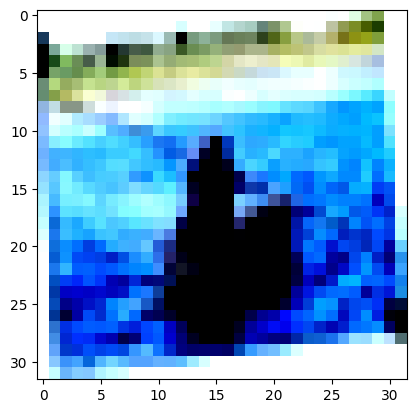

In [32]:
# visualize a sample from the train loader

batch_images, batch_labels = next(train_iter)

image, label = batch_images[78], batch_labels[78]

print(image.shape, label)

plt.imshow(image.permute(1,2,0))
plt.show()

In [34]:
# nn.Conv2d(input channels, output channels, kernel size, padding, stride)

# W_output = ((W-K+2P)/S)+1
# H_output = ((H-K+2P)/S)+1

# W = old width
# H = old height
# K = kernel size
# P = padding
# S = stride

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # build our layers
    # first layer

    # input channels - 3 (R, G, B)
    # output channels - 32 feature maps
    # kernel size - 3x3 matrix
    # padding - 1 (around outside of image to make matrix multiplication work at edges of image)
    # stride - how many steps we take when we move our kernel
    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1, stride = 4)

    # batch size x 3 (number of input channels) x 32 (width) x 32 (height)
    # batch size x 32 (output channels) x 32 x 32

    self.batchnorm1 = nn.BatchNorm2d(32)

    # activation function ReLU(x) = max(0, x)
    self.relu1 = nn.ReLU()

    # using max pooling rather than avg pooling
    self.pool1 = nn.MaxPool2d(2,2)
    # batch size x 32 x 32 x 32 --> batch size x 32 x 16 x 16

    # dropout prevents neural network from becoming too "reliant" on any singular node in the network
    self.dropout1 = nn.Dropout(0.05)

    # second layer, note that num input channels is equiv num output channels of prev convolutional step
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1, stride = 1)
    # batch size x 32 x 16 x 16 --> batch size x 64 x 16 x 16
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2,2)
    # batch size x 64 x 16 x 16 --> batch size x 64 x 8 x 8
    self.dropout2 = nn.Dropout(0.05)

    # third layer
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1, stride = 1)
    # batch size x 64 x 8 x 8 --> batch size x 128 x 8 x 8
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(2,2)
    # batch size x 128 x 8 x 8 --> batch size x 128 x 4 x 4
    self.dropout3 = nn.Dropout(0.05)

    # flatten our last layer to prep for linear layers
    self.flatten = nn.Flatten()
    # batch size x 128 x 4 x 4 --> batch size x (128x4x4)

    # linear layers

    # nn.Linear(number of input nodes, number of output nodes)
    self.fc1 = nn.Linear(128*4*4, 256)
    self.relu4 = nn.ReLU()

    self.fc2 = nn.Linear(256, 128)
    self.relu5 = nn.ReLU()

    self.fc3 = nn.Linear(128, 10)
    # final dimension is batch size x 10
    # there are 10 total classifications

  # x is an image
  def forward(self, x):
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.dropout1(x)

    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    x = self.dropout2(x)

    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = self.relu3(x)
    x = self.pool3(x)
    x = self.dropout3(x)

    x = self.flatten(x)

    x = self.fc1(x)
    x = self.relu4(x)

    x = self.fc2(x)
    x = self.relu5(x)

    x = self.fc3(x)
    return x

In [35]:
# create a model and load it onto our device
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.05, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.05, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.05, inplace=False)
  (flatten): Flatten(start_d